In [50]:
import torch
import numpy as np
from focus import FOCUS
import copy as copy

seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

noise_scale = 0.0
learning_rate = 1e-3
batch_size = 128

noise_scales = 10 ** np.linspace(-3,0,num=10)
batch_sizes = [8,16,32,64,128,256,512,1024]
learning_rates = 10 ** np.linspace(-5,-1,num=9)

best_N0s = []

for noise_scale in noise_scales:
#for learning_rate in learning_rates:
#for batch_size in batch_sizes:
    
    #print('batch_size={}'.format(batch_size))
    print('noise={}'.format(noise_scale))
    #print('lr={}'.format(learning_rate))

    # get task vectors. all orthogonal
    dim = 1000
    n_task = 10
    gaus = torch.randn(dim, dim)
    #u, s, v = torch.svd(gaus)
    u = torch.randn(n_task, dim)
    u = u/torch.norm(u, dim=1, keepdim=True)

    # power law distribution
    alpha = 2
    prob = 1/(np.arange(n_task) + 1)**(alpha)
    prob /= np.sum(prob)




    task_vectors = u[:n_task]

    #batch_size = 128

    # initial and target
    x = torch.nn.Parameter(torch.zeros(dim,))

    #learning_rate = 1e-2
    #optimizer = torch.optim.SGD([x], lr=learning_rate)
    optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.0,0.0))
    #optimizer = FOCUS([x], lr=learning_rate, betas=(0.9,0.99), gamma=0.2)
    target = torch.sum(task_vectors, dim=0)


    n_steps = 1000
    log = 500
    task_abilities = []
    losses = []
    losses_skill = []
    n_uses = []


    for i in range(n_steps):

        optimizer.zero_grad()

        # project and get progress
        task_ability = task_vectors @ x

        loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
        task_abilities.append(task_ability.detach().numpy())
        losses.append(loss)
        losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

        # mimic gradient
        id = np.random.choice(n_task, batch_size, p=prob)
        task_vectors_batch = task_vectors[id]
        task_ability_batch = task_ability[id]

        #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
        #neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

        #neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)
        loss = torch.mean((1-task_ability_batch)**2)
        loss.backward()

        x.grad.data += noise_scale * torch.randn(dim,)

        # update 
        #x.grad = - neg_grad + torch.randn(dim) * noise_scale
        optimizer.step()



        neg_grad = - x.grad.detach()

        # compute #(used dimension)
        alignment = task_vectors * neg_grad[None, :] > 0
        n_used = torch.sum(alignment, dim=1)
        n_uses.append(n_used.detach().numpy())

        if i % log == 0:
            print(i)

    task_abilities = np.array(task_abilities)
    losses = np.array(losses)
    n_uses = np.array(n_uses)
    losses_skill = np.array(losses_skill)
    
    N0s = 10 ** np.linspace(-4,2,num=601)

    fit_errors = []

    for N0 in N0s:
        l = np.ones(n_task,)

        lr = learning_rate * np.sqrt(dim) * 2
        n_steps2 = 1000

        ls = []

        #N0 = 0.001

        for i in range(n_steps2):
            fg = prob * l
            fg_norm = fg/(np.sum(fg) + N0)
            l -= lr * fg_norm
            l = np.maximum(l, 0.)
            #l = np.exp(-lr*prob/(np.sum(fg)+0.01)) * l
            ls.append(copy.deepcopy(l))

        ls = 1 - np.array(ls)
        fit_errors.append(np.mean((task_abilities - ls)**2))
        
    best_N0 = N0s[np.argmin(fit_errors)]
    print(best_N0)
    best_N0s.append(best_N0)

noise=0.001
0
500
0.03162277660168379
noise=0.0021544346900318847
0
500
0.06456542290346556
noise=0.004641588833612777
0
500
0.15135612484362088
noise=0.01
0
500
0.3388441561392027
noise=0.021544346900318832
0
500
0.7244359600749899
noise=0.046415888336127774
0
500
1.4125375446227553
noise=0.09999999999999999
0
500
3.890451449942805
noise=0.21544346900318823
0
500
8.91250938133746
noise=0.4641588833612777
0
500
18.62087136662869
noise=1.0
0
500
37.153522909717275


In [51]:
np.save('./best_N0_noise.npy', best_N0s)
#np.save('./best_N0_lr.npy', best_N0s)
#np.save('./best_N0_bs.npy', best_N0s)

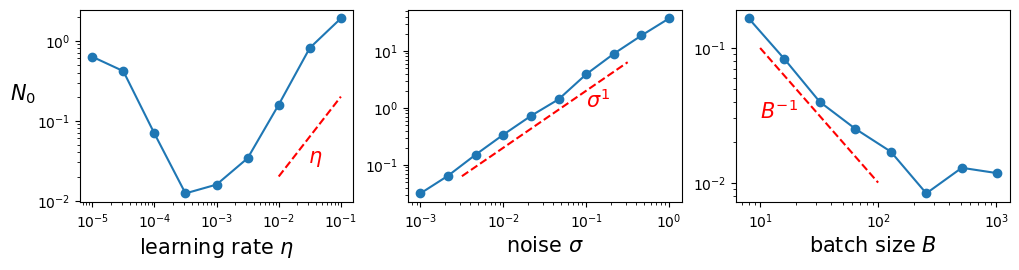

In [8]:
import numpy as np
import matplotlib.pyplot as plt

noise_scales = 10 ** np.linspace(-3,0,num=10)
batch_sizes = [8,16,32,64,128,256,512,1024]
learning_rates = 10 ** np.linspace(-5,-1,num=9)

plt.figure(figsize=(12,2.5))

plt.subplot(1,3,1)

best_N0s = np.load('./best_N0_lr.npy')
plt.plot(learning_rates, best_N0s, marker='o')

x0 = 10**np.linspace(-2,-1,num=101)
plt.plot(x0, 2*x0, color='red',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.text(0.03,0.03,r'$\eta$', fontsize=15, color='red')
plt.xlabel(r'learning rate $\eta$', fontsize=15)
plt.ylabel(r'$N_0$', fontsize=15, rotation=0, labelpad=10)

plt.subplot(1,3,2)

best_N0s = np.load('./best_N0_noise.npy')
plt.plot(noise_scales, best_N0s, marker='o')

x0 = 10 ** np.linspace(-2.5,-0.5,num=101)
plt.plot(x0, 20*x0, ls='--', color='red')
plt.text(0.1,1,r'$\sigma^1$', fontsize=15, color='red')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'noise $\sigma$', fontsize=15)

plt.subplot(1,3,3)

best_N0s = np.load('./best_N0_bs.npy')
plt.plot(batch_sizes, best_N0s, marker='o')

x0 = 10 ** np.linspace(1,2,num=101)
plt.plot(x0, 1/x0, ls='--', color='red')
plt.text(10,0.03,r'$B^{-1}$', fontsize=15, color='red')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'batch size $B$', fontsize=15)
#plt.ylabel(r'$N_0$', fontsize=20, rotation=0, labelpad=10)
plt.savefig('./plot/N0_dependence.pdf', bbox_inches='tight')

Text(0, 0.5, '$N_0$')

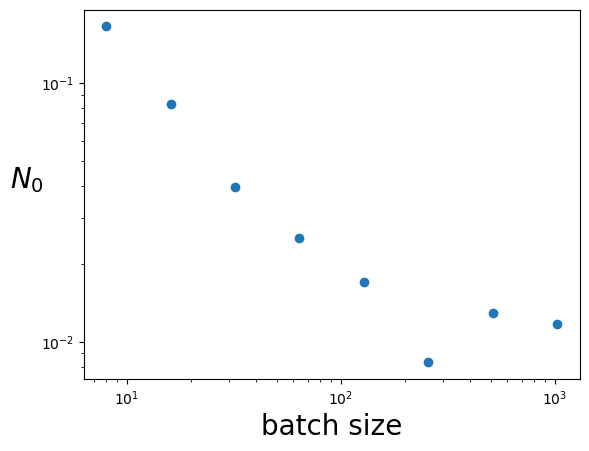

In [49]:
import matplotlib.pyplot as plt

plt.scatter(batch_sizes, best_N0s)

#plt.plot(x0, x0*10, color='red',ls='--')
plt.xscale('log')
plt.yscale('log')
#plt.text(0.1,0.6,r'$\eta^{-1}$', fontsize=20, color='red')
plt.xlabel('batch size', fontsize=20)
plt.ylabel(r'$N_0$', fontsize=20, rotation=0, labelpad=10)

Text(0, 0.5, '$N_0$')

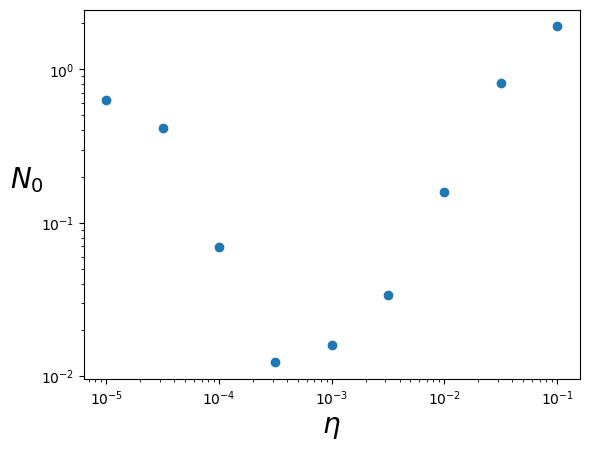

In [35]:
import matplotlib.pyplot as plt

plt.scatter(learning_rates, best_N0s)

x0 = 10**np.linspace(-2,0,num=101)
#plt.plot(x0, x0*10, color='red',ls='--')
plt.xscale('log')
plt.yscale('log')
#plt.text(0.1,0.6,r'$\eta^{-1}$', fontsize=20, color='red')
plt.xlabel(r'$\eta$', fontsize=20)
plt.ylabel(r'$N_0$', fontsize=20, rotation=0, labelpad=10)

Text(0, 0.5, '$N_0$')

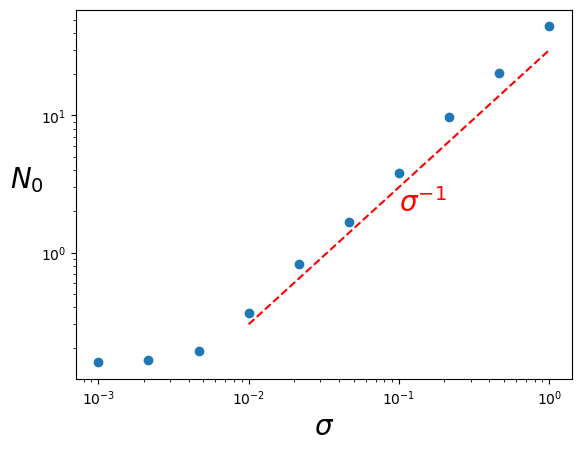

In [44]:
import matplotlib.pyplot as plt

plt.scatter(noise_scales, best_N0s)

x0 = 10**np.linspace(-2,0,num=101)
plt.plot(x0, x0*30, color='red',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.text(0.1,2,r'$\sigma^{-1}$', fontsize=20, color='red')
plt.xlabel(r'$\sigma$', fontsize=20)
plt.ylabel(r'$N_0$', fontsize=20, rotation=0, labelpad=10)

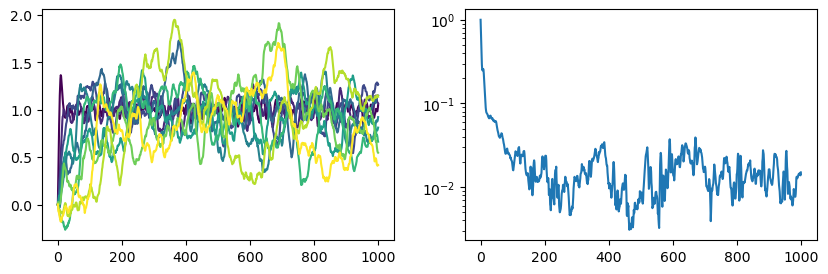

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))

cmap = plt.get_cmap('viridis') 

plt.subplot(1,2,1)

for i in range(n_task):
    plt.plot(task_abilities[:,i], color=cmap(i/(n_task-1)))
    
#plt.xlim(1,300)
#plt.xscale('log')
    
plt.subplot(1,2,2)
plt.plot(losses)
plt.yscale('log')

losses1 = copy.deepcopy(losses)

In [173]:
N0s = 10 ** np.linspace(-4,1,num=201)

fit_errors = []

for N0 in N0s:
    l = np.ones(n_task,)

    lr = learning_rate * np.sqrt(dim) * 2
    n_steps2 = 1000

    ls = []

    #N0 = 0.001

    for i in range(n_steps2):
        fg = prob * l
        fg_norm = fg/(np.sum(fg) + N0)
        l -= lr * fg_norm
        l = np.maximum(l, 0.)
        #l = np.exp(-lr*prob/(np.sum(fg)+0.01)) * l
        ls.append(copy.deepcopy(l))

    ls = 1 - np.array(ls)
    fit_errors.append(np.mean((task_abilities - ls)**2))

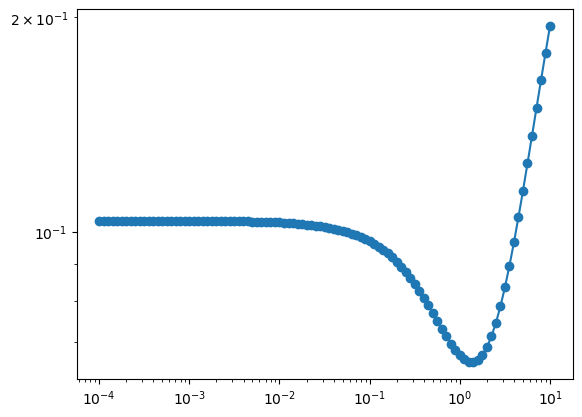

In [174]:
plt.plot(N0s, fit_errors, marker='o')
plt.xscale('log')
plt.yscale('log')